In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

#%config InlineBackend.figure_format = 'svg'
#Отключено для ускорения вычислений sns.pairplot(df[feature_num_names]);
%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
def evaluate_preds(true_values_train, pred_values_train, true_values_test, pred_values_test):
    print('Train:\t' + 'R2 = ' + str(round(r2_score(true_values_train, pred_values_train), 3)) + 
          '\tMAE = ' + str(int(mean_absolute_error(true_values_train, pred_values_train))) +
          '\n' +
          'Test:\t' + 'R2 = ' + str(round(r2_score(true_values_test, pred_values_test), 3)) +
          '\tMAE = ' + str(int(mean_absolute_error(true_values_test, pred_values_test)))
         )
    
    sns.set(font_scale=1)
    plt.figure(figsize=(16, 6))
       
    plt.subplot(121)
    sns.scatterplot(x=pred_values_train, y=true_values_train)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Значения целевой переменной')
    plt.title('Анализ модели на тренировочных данных');
    
    plt.subplot(122)
    sns.scatterplot(x=pred_values_test, y=true_values_test)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Значения целевой переменной')
    plt.title('Анализ модели на тестовых данных');

#### Пути к директориям и файлам

In [3]:
DATASET_PATH = 'train.csv'
DATASET_PATH_TEST = 'test.csv'
DATASET_PRED_PATH = 'AZhilin_predictions.csv'
SCALER_FILE_PATH = 'scaler.pkl'
MODEL_FILE_PATH = 'model.pkl'

# Загрузка и анализ данных

In [4]:
df = pd.read_csv(DATASET_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [5]:
df.shape

(10000, 20)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [7]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [8]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


## Обработка пропусков

In [9]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

#### LifeSquare

In [10]:
#Замена пропусков медианными значениями жилой площади сгруппированными по комнатам
df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df.groupby(['Rooms'])['LifeSquare'].transform(lambda x: x.median())

#### Healthcare_1

In [11]:
df['Helthcare_2'].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

In [12]:
#Замена пропусков на медианные значения сгруппированные по признаку Helthcare_2
df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] =\
df.groupby(['Helthcare_2'])['Healthcare_1'].transform(lambda x: x.median())

In [13]:
#Проверка заполнения
df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

## Обработка выбросов

### Год постройки

In [14]:
df[df['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


In [15]:
#Замена 20.05.2011 на 2011
df.loc[df['HouseYear'] ==20052011, 'HouseYear'] = 2011
#Замена на медиану
df.loc[df['Id']==11607, 'HouseYear'] = df['HouseYear'].median()

### Площадь кухни

In [16]:
df[df['KitchenSquare'] > 50]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
227,16395,2,3.0,79.722243,44.731219,72.0,12,16.0,1987.0,0.130618,B,B,39,10418,9,900.0,1,9,B,370148.625285
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014.0,0.072158,B,B,2,629,1,540.0,0,0,A,108337.484207
1369,2371,27,2.0,68.841073,64.234956,66.0,4,2.0,2014.0,0.017647,B,B,2,469,0,540.0,0,0,B,189244.249909
1455,12507,54,2.0,79.810535,79.578961,78.0,10,15.0,2014.0,0.006076,B,B,30,5285,0,645.0,6,6,B,438708.707579
1860,4265,161,2.0,53.216778,32.644859,53.0,7,17.0,1994.0,0.000699,B,B,14,3369,24,4129.0,0,3,B,261125.669724
2916,12390,72,3.0,97.490674,99.323558,96.0,22,25.0,2019.0,0.210473,B,B,11,2398,2,1994.0,3,0,B,445074.956552
2969,7441,62,3.0,114.734473,112.589083,112.0,3,3.0,2015.0,0.072158,B,B,2,629,1,540.0,0,0,A,315245.521059
4079,6508,23,2.0,67.146049,33.959154,63.0,5,17.0,2019.0,0.034656,B,B,0,168,0,540.0,0,0,B,193130.585871
4110,299,27,2.0,66.787523,64.616662,60.0,14,20.0,2015.0,0.017647,B,B,2,469,0,540.0,0,0,B,179466.094235
4651,12552,58,3.0,116.405693,113.109653,112.0,3,3.0,2016.0,0.437885,B,B,23,5735,3,1084.0,0,5,B,296165.936689


In [17]:
#Замена на медиану
df.loc[df['KitchenSquare'] > 50, 'KitchenSquare'] = df['KitchenSquare'].median()

### Площадь

In [18]:
df[df['LifeSquare'] > 200]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
590,14990,23,2.0,48.449873,263.542020,5.0,6,5.0,1972.0,0.075779,B,B,6,1437,3,540.0,0,2,B,141780.231857
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008.0,0.211401,B,B,9,1892,0,540.0,0,1,B,302211.260887
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011.0,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
4328,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016.0,0.017647,B,B,2,469,0,540.0,0,0,B,217357.492366
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016.0,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019.0,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562
8437,15886,85,3.0,78.059331,461.463614,10.0,12,16.0,1998.0,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.299978
9910,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013.0,0.041116,B,B,53,14892,4,620.0,1,4,B,528560.506016


In [19]:
#Замена площади у дома с площадью > 200 на медианную
df.loc[df['LifeSquare'] > 200, 'LifeSquare'] = df['LifeSquare'].median()

In [20]:
df[df['Square'] > 200]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1981,7917,27,0.0,212.932361,32.552134,0.0,2,3.0,2008.0,0.211401,B,B,9,1892,0,540.0,0,1,B,302211.260887
1982,5548,86,5.0,275.645284,32.552134,26.0,12,37.0,2011.0,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
4262,28,9,2.0,604.705972,32.552134,1.0,17,18.0,1977.0,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
4690,2307,102,1.0,409.425181,32.552134,10.0,4,4.0,2016.0,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
6977,11602,30,2.0,641.065193,32.552134,10.0,20,19.0,2019.0,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562
9910,16568,27,4.0,200.334539,32.552134,25.0,1,2.0,2013.0,0.041116,B,B,53,14892,4,620.0,1,4,B,528560.506016


In [21]:
#Замена общей площади на медианную
df.loc[df['Square'] > 200, 'Square'] = df['Square'].median()

### Этажность сданий

In [22]:
df[df['HouseFloor'] > 60]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6131,10806,5,1.0,51.944587,48.709601,1.0,6,99.0,1977.0,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.115515
8599,9300,74,2.0,71.747869,74.579809,9.0,5,99.0,1977.0,0.075779,B,B,6,1437,3,540.0,0,2,B,243329.912579
8854,78,30,2.0,65.773749,66.811789,1.0,8,117.0,1977.0,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.370520


In [23]:
# Замена этажности сдания на медианную
df.loc[df['HouseFloor'] > 60, 'HouseFloor'] = df['HouseFloor'].median()

In [24]:
df[df['HouseFloor'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,32.552134,0.0,14,0.0,1977.0,0.075779,B,B,6,1437,3,540.0,0,2,B,221244.156664
23,6641,54,3.0,118.907612,46.960480,0.0,2,0.0,1977.0,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018.0,0.072158,B,B,2,629,1,540.0,0,0,A,337299.867936
39,9371,23,2.0,60.503248,32.552134,0.0,16,0.0,1977.0,0.034656,B,B,0,168,0,540.0,0,0,B,229778.057902
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017.0,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,12302,30,1.0,46.072913,48.307844,0.0,4,0.0,1977.0,0.000078,B,B,22,6398,141,1046.0,3,23,B,161403.094034
9769,9384,59,3.0,98.607328,46.960480,0.0,14,0.0,1977.0,0.019509,B,B,37,7687,11,176.0,5,5,B,492700.257473
9878,11441,62,2.0,71.985335,72.453232,0.0,5,0.0,1977.0,0.072158,B,B,2,629,1,540.0,0,0,A,158841.624543
9908,3171,62,1.0,35.873961,21.663929,0.0,25,0.0,1977.0,0.072158,B,B,2,629,1,540.0,0,0,A,134379.130962


In [25]:
df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()

### Комнаты в домах

In [26]:
#Проверка домов у которых нет комнат
df[(df['Rooms'] == 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016.0,0.075424,B,B,11,3097,0,540.0,0,0,B,268394.744389
1981,7917,27,0.0,52.513310,32.552134,0.0,2,3.0,2008.0,0.211401,B,B,9,1892,0,540.0,0,1,B,302211.260887
2269,7317,27,0.0,41.790881,85.125471,0.0,13,13.0,1977.0,0.211401,B,B,9,1892,0,540.0,0,1,B,98129.976788
3911,770,28,0.0,49.483501,85.125471,0.0,16,13.0,2015.0,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0.0,81.491446,85.125471,0.0,4,13.0,1977.0,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,13.0,1977.0,0.017647,B,B,2,469,0,540.0,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982.0,0.127376,B,B,43,8429,3,1145.0,3,9,B,158998.110646
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977.0,0.211401,B,B,9,1892,0,540.0,0,1,B,219281.918007


In [27]:
# Медианная площадь комнаты в однокомнатной квартире
medSqRoom = df.loc[(df['Rooms'] ==1, 'LifeSquare')].median()
# Замена нулевого значения, значениями жилой площади / medSqRoom
df.loc[(df['Rooms'] == 0), 'Rooms'] = np.array(df.loc[(df['Rooms'] ==0, 'LifeSquare')] / medSqRoom + 0.5, dtype=int)

In [28]:
# Подставление 1,в оставшихся случаях (int() = 0)
df.loc[(df['Rooms'] == 0, 'Rooms')] = 1

In [29]:
#Проверка
df.loc[df['Rooms'] == 0, 'Rooms'].count()

0

In [30]:
#Проверка домов у которых количество комнат больше или равно 10
df[(df['Rooms'] >= 10)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002.0,0.090799,B,B,74,19083,2,1575.0,5,15,B,317265.323792
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014.0,0.007122,B,B,1,264,0,540.0,0,1,B,78364.616704
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994.0,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


In [31]:
df.loc[(df['Rooms'] > 10, 'Rooms')] = 1
df.loc[(df['Rooms'] == 10, 'Rooms')] = 2

### Замена значений Square и LifeSquare, где LifeSquare > Square

In [32]:
#Проверка количества домов у которых жилая площадь больше общей площади
df.loc[df['Square'] < df['LifeSquare'], 'Square'].count()

485

In [33]:
#Меняем их местами
df['temp'] = df['Square']

df.loc[df['Square'] < df['LifeSquare'], 'Square'] = df.loc[df['Square'] < df['LifeSquare'], 'LifeSquare']
df.loc[df['temp'] < df['LifeSquare'], 'LifeSquare'] = df.loc[df['temp'] < df['LifeSquare'], 'temp']
df.drop("temp", axis=1, inplace=True)

In [34]:
#Повторная проверка
df.loc[df['Square'] < df['LifeSquare'], 'Square'].count()

0

## Анализ признаков влияющих на целевую переменную

### Бинарные признаки

In [35]:
df.describe(include='object')

,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000
unique,2,2,2
top,B,B,B
freq,9903,9725,9175


In [36]:
#Ecology_2
Ecology_2_col = pd.get_dummies(df['Ecology_2'])
Ecology_2_col.columns = ['Ecology_2_A', 'Ecology_2_B']
df = pd.concat([df, Ecology_2_col], axis=1)

In [37]:
#Ecology_3
Ecology_3_col = pd.get_dummies(df['Ecology_3'])
Ecology_3_col.columns = ['Ecology_3_A', 'Ecology_3_B']
df = pd.concat([df, Ecology_3_col], axis=1)
#df[Ecology_3_col.columns] = Ecology_3_col

In [38]:
#Shops_2
Shops_2_col = pd.get_dummies(df['Shops_2'])
Shops_2_col.columns = ['Shops_2_A', 'Shops_2_B']
df = pd.concat([df, Shops_2_col], axis=1)

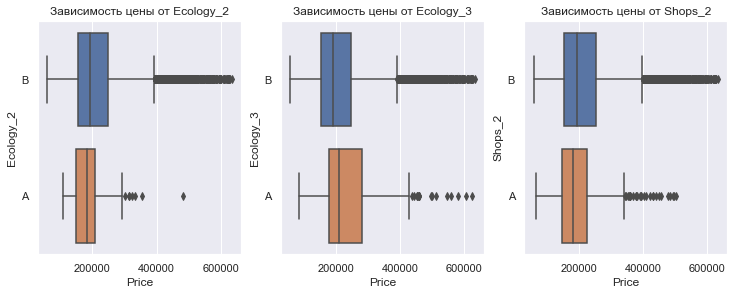

In [39]:
#Графическое представление
sns.set(font_scale=1)
plt.figure(figsize = (11,4))

plt.subplot(1,3,1)
sns.boxplot(df['Price'], df['Ecology_2'])
plt.xlabel('Price')
plt.ylabel('Ecology_2')
plt.title('Зависимость цены от Ecology_2');

plt.subplot(1,3,2)
sns.boxplot(df['Price'], df['Ecology_3'])
plt.xlabel('Price')
plt.ylabel('Ecology_3')
plt.title('Зависимость цены от Ecology_3');

plt.subplot(1,3,3)
sns.boxplot(df['Price'], df['Shops_2'])
plt.xlabel('Price')
plt.ylabel('Shops_2')
plt.title('Зависимость цены от Shops_2');

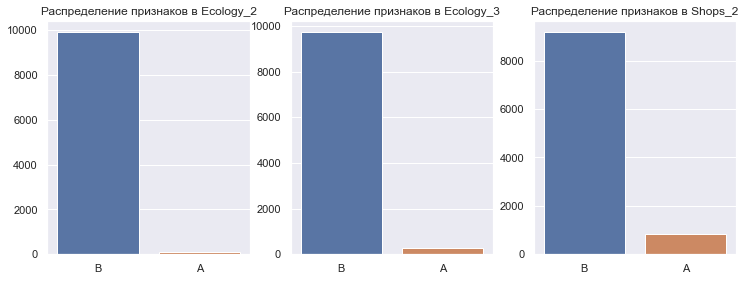

In [40]:
sns.set(font_scale=1)
plt.figure(figsize = (11,4))

plt.subplot(1,3,1)
counts = df['Ecology_2'].value_counts()
sns.barplot(counts.index, counts.values)
plt.title('Распределение признаков в Ecology_2');

plt.subplot(1,3,2)
counts = df['Ecology_3'].value_counts()
sns.barplot(counts.index, counts.values)
plt.title('Распределение признаков в Ecology_3');

plt.subplot(1,3,3)
counts = df['Shops_2'].value_counts()
sns.barplot(counts.index, counts.values)
plt.title('Распределение признаков в Shops_2');

#### Удаление домов с площадью менее 15 м2

In [41]:
df.drop(df[(df['Square'] < 15)].index, inplace=True)
df.shape

(9991, 26)

### Количественные признаки

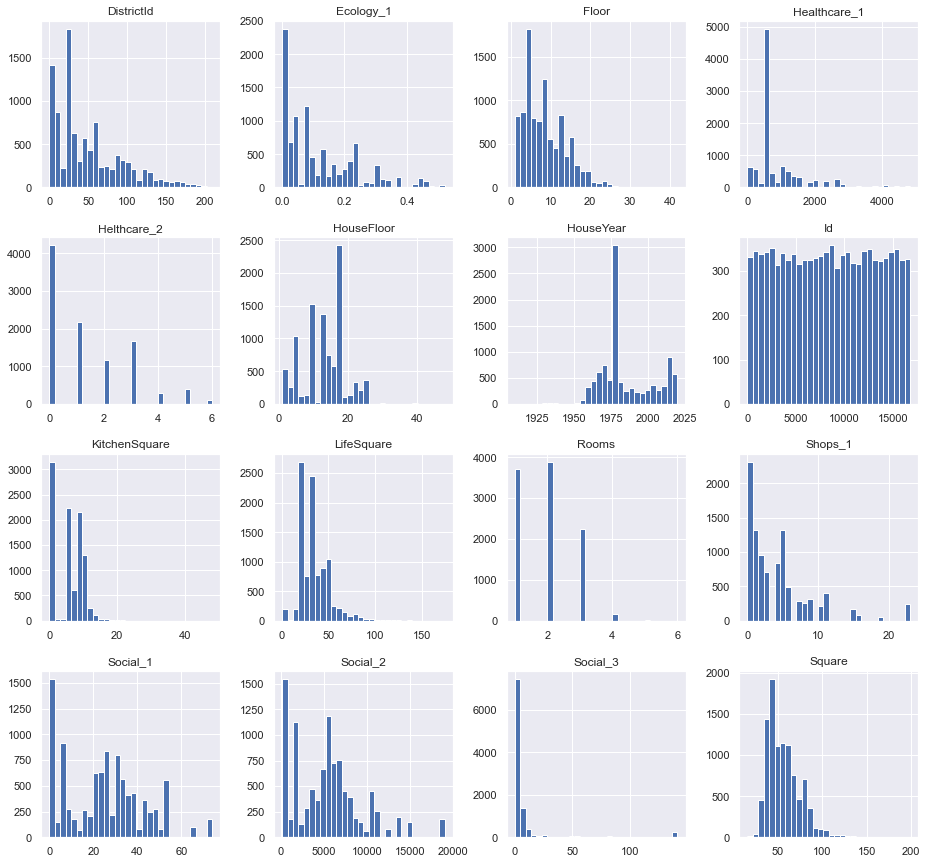

In [42]:
feature_num_names = df.drop("Price", axis=1).select_dtypes(include=['float64', 'int64']).columns.tolist()
df[feature_num_names].hist(figsize=(14,14), bins=30);

### Прологарифмированные показатели rколичественных признаков

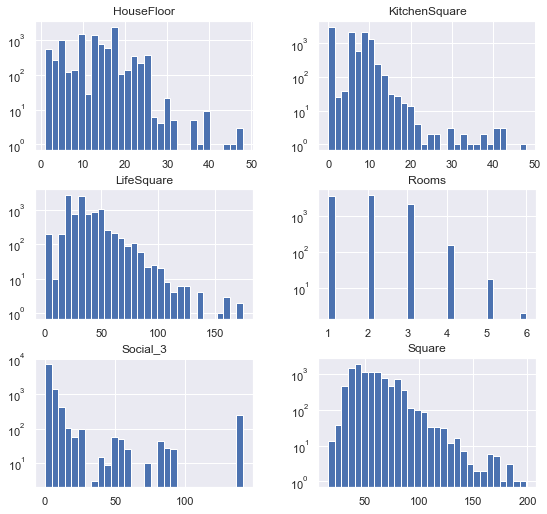

In [43]:
feature_num_names = ['LifeSquare', 'KitchenSquare', 'Square', 'Rooms', 'Social_3', 'HouseFloor']
df[feature_num_names].hist(figsize=(8,8), bins=30, log=True);

## Построение новых признаков

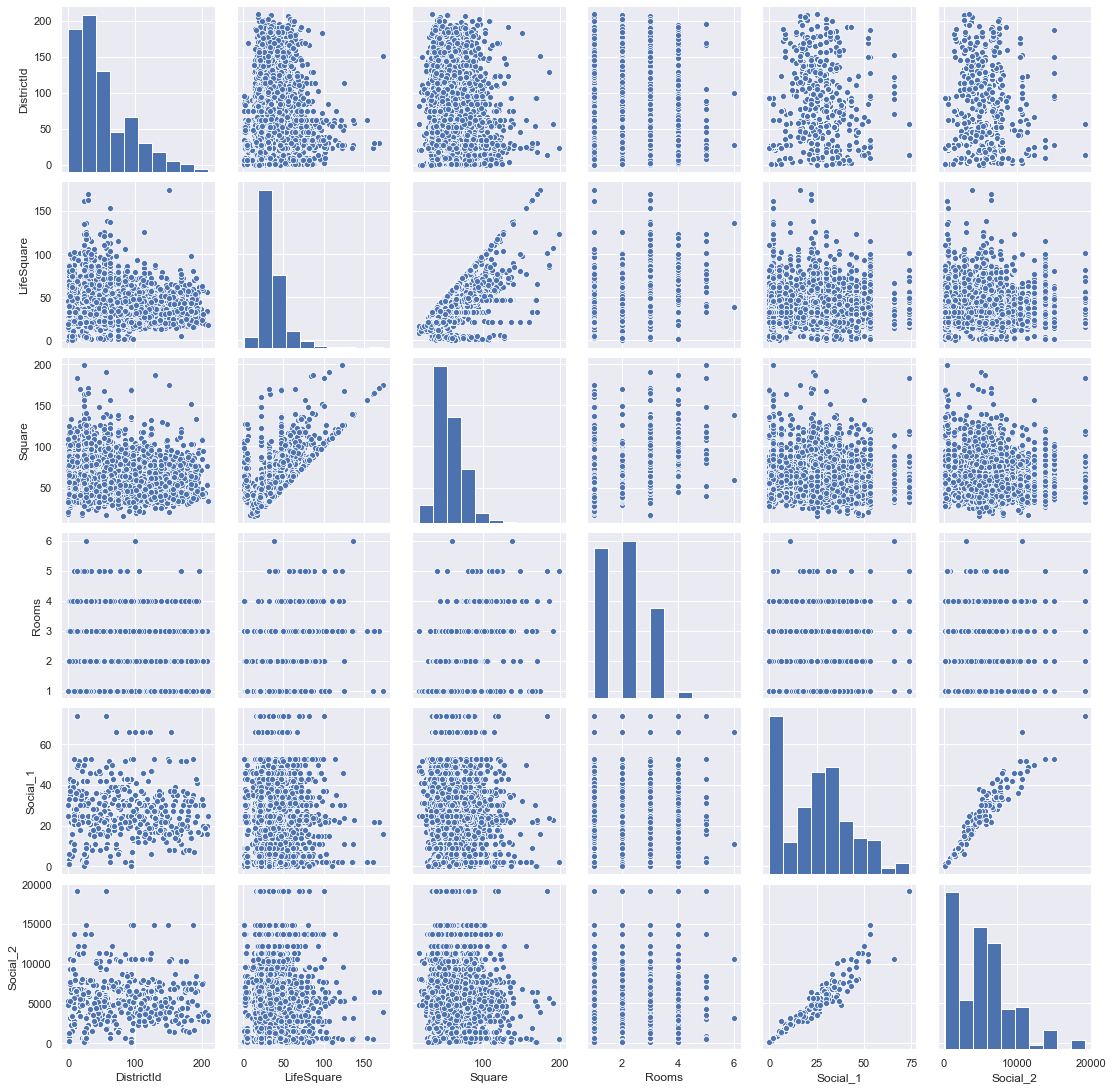

In [44]:
#Анализ взаимозависимости показателей
feature_num_names = ['DistrictId', 'LifeSquare', 'Square', 'Rooms', 'Social_1', 'Social_2']
sns.set()
sns.pairplot(df[feature_num_names]);

In [45]:
#Отношение количества комнат к жилой площади (площадь комнаты + дополнительные помещения)
df['SquareOtn'] = df['Rooms']/df['Square']

## Корреляция данных

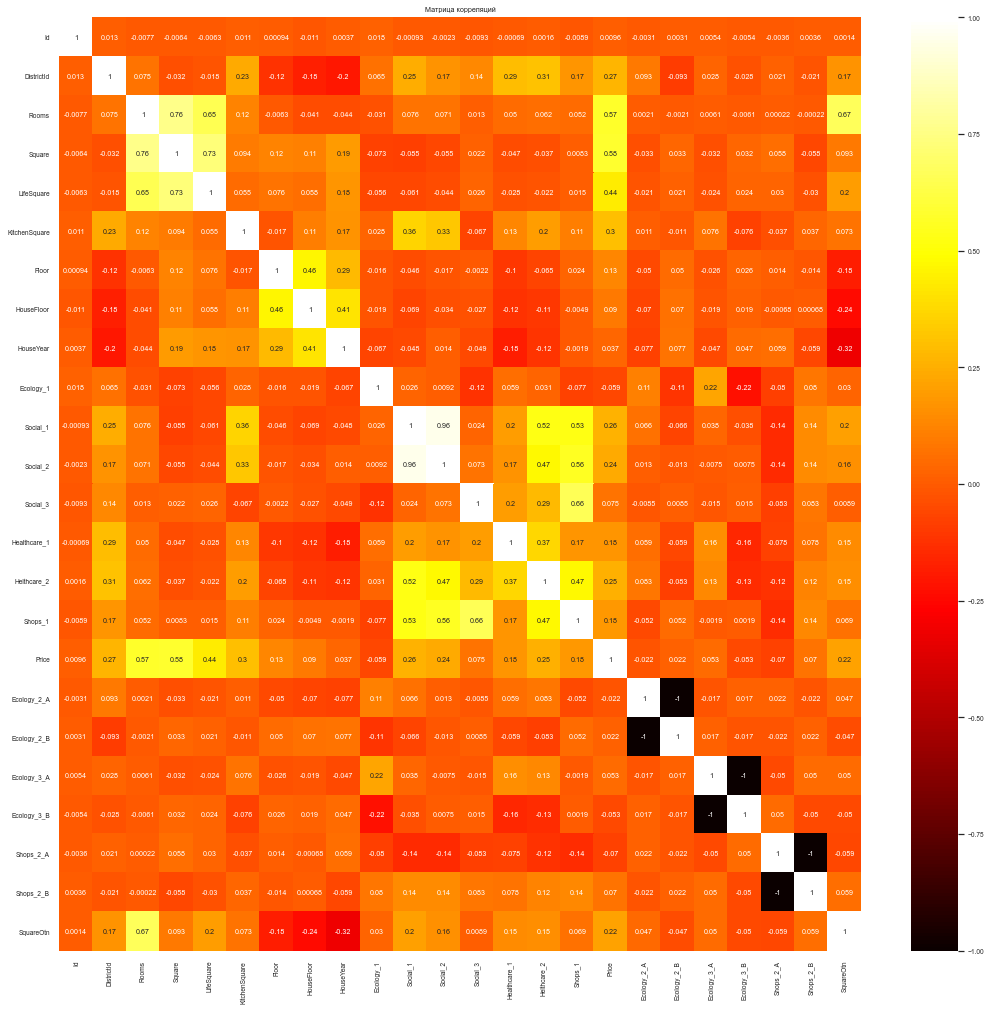

In [46]:
#Нахождение наиболее коррелирующих признаков
plt.figure(figsize = (16,16))
sns.set(font_scale=0.6)
sns.heatmap(df.corr(),annot=True,cmap='hot')
plt.title("Матрица корреляций");

#Возвращаю масштаб текста
sns.set(font_scale=1)

In [47]:
#Нахождение наиболее значимых признаков для целевой переменной
df.corr()['Price'].sort_values()

Shops_2_A       -0.070313
Ecology_1       -0.058512
Ecology_3_B     -0.052755
Ecology_2_A     -0.022352
Id               0.009589
Ecology_2_B      0.022352
HouseYear        0.037246
Ecology_3_A      0.052755
Shops_2_B        0.070313
Social_3         0.075020
HouseFloor       0.090315
Floor            0.127816
Healthcare_1     0.178898
Shops_1          0.180404
SquareOtn        0.218319
Social_2         0.238997
Helthcare_2      0.252954
Social_1         0.263171
DistrictId       0.265642
KitchenSquare    0.297667
LifeSquare       0.437193
Rooms            0.571635
Square           0.580885
Price            1.000000
Name: Price, dtype: float64

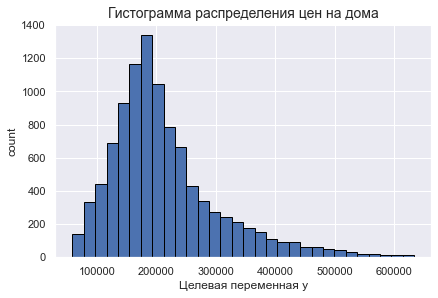

In [48]:
#Целевая переменная
y = df["Price"]

label_font = {"fontsize": 14}

plt.hist(y, bins=30, ec="black")
plt.title("Гистограмма распределения цен на дома", fontdict=label_font)
plt.xlabel("Целевая переменная y")
plt.ylabel('count')
plt.show()

## Обучение моделей

### Разбиение выборки на тренировочную и тестовую

In [49]:
#Для получения тренировочной и тестовой выборки исключаем:
#1) бинарные переменные, т.к в итоговой тестовой модели они имели наименьший вес (почти 0)
#2) номера домов - Id
#3) целевeую переменную - Price
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'SquareOtn']
X = pd.DataFrame(df, columns=feature_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
print("Размер тренировочной выборки = {}, Размер целевой переменной = {}".format(X_train.shape, y_train.shape))
print("Разамер тестовой выборки = {}, Размер целевой переменной = {}".format(X_test.shape, y_test.shape))

Размер тренировочной выборки = (6993, 16), Размер целевой переменной = (6993,)
Разамер тестовой выборки = (2998, 16), Размер целевой переменной = (2998,)


### Масштабирование признаков

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Построение и обучение моделей

#### LinearRegression

In [52]:
#Построение модели линейной регрессии
lr_model = LinearRegression()

In [53]:
#Обучение модели
lr_model.fit(X_train_scaled, y_train);

In [54]:
#Получение предсказания целевой переменной
y_pred_train = lr_model.predict(X_train_scaled)
y_pred_test = lr_model.predict(X_test_scaled)

Train:	R2 = 0.53	MAE = 43367
Test:	R2 = 0.568	MAE = 44108


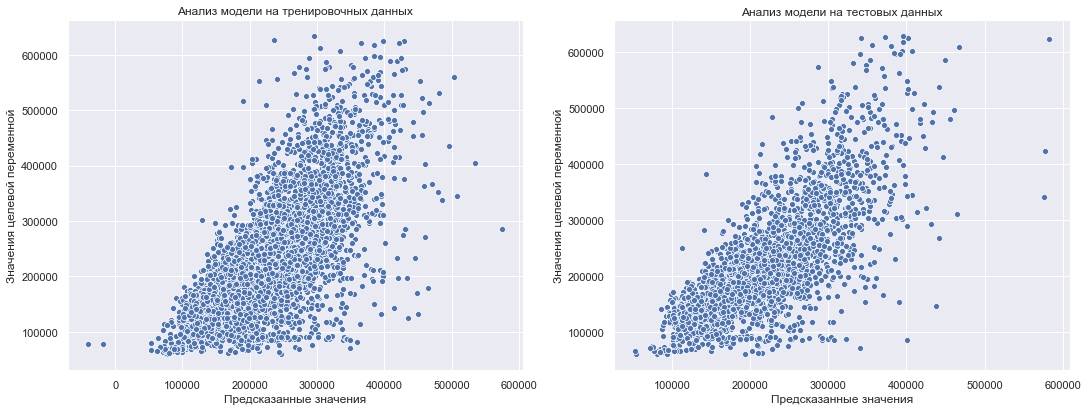

In [55]:
evaluate_preds(y_train, y_pred_train, y_test, y_pred_test)

In [56]:
#Метрика R2 < 0.65 Необходимо подобрать другую модель

#### Random Forest

In [57]:
#Построение модели случайного леса
rf_model = RandomForestRegressor(random_state=42)

In [58]:
#Обучение модели
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [59]:
#Получение предсказания целевой переменной
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

Train:	R2 = 0.959	MAE = 10721
Test:	R2 = 0.751	MAE = 28730


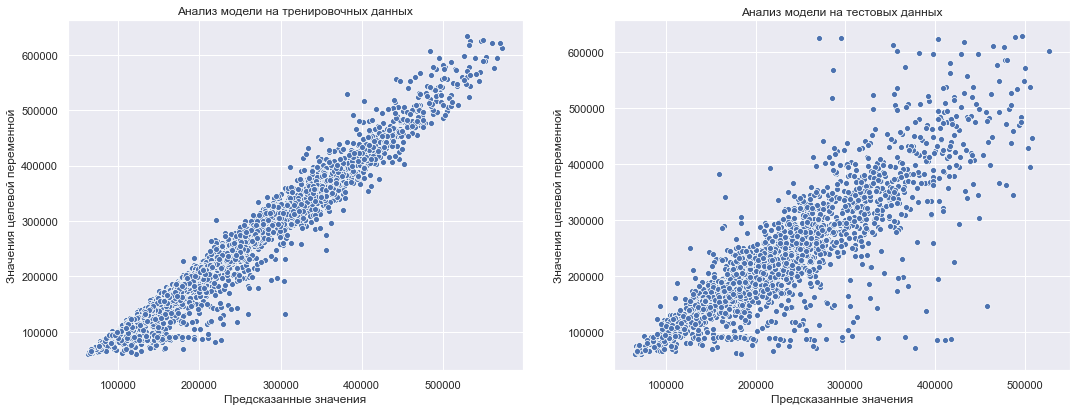

In [60]:
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [61]:
#Метрика R2 > 0.65 Модель подходит для выполнения предсказаний цены

#### Градиентный бустинг

In [62]:
#Построение модели
gb_model = GradientBoostingRegressor(n_estimators=200, max_depth=7, random_state=42)

In [63]:
#Масштабирование признаков на 0.01 ухудшило качество модели, поэтому обучение проходит на стандартных признаках

#Обучение модели
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=7, n_estimators=200, random_state=42)

In [64]:
#Получение предсказания целевой переменной
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)

Train:	R2 = 0.967	MAE = 11661
Test:	R2 = 0.756	MAE = 27849


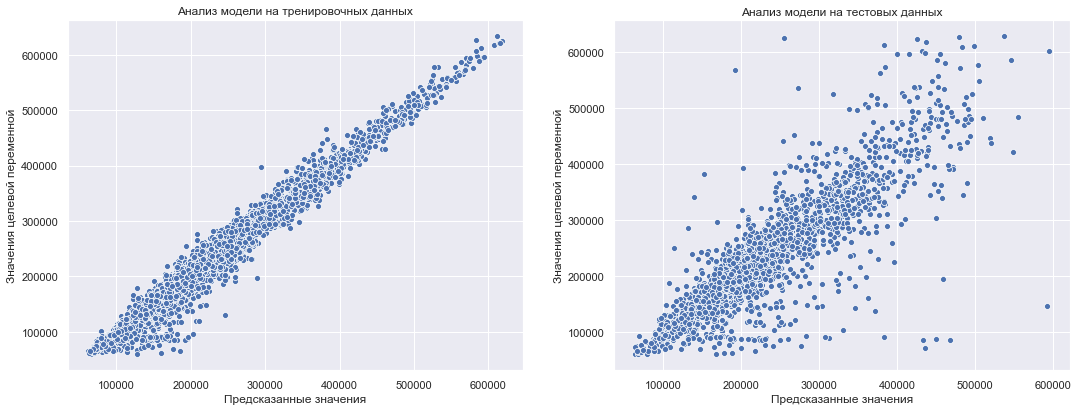

In [65]:
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [66]:
#Метрика R2 > 0.65 Модель подходит для выполнения предсказаний цены - Самая точная модель

## Настройка и оценка финальной модели

### Определение оптимальных параметров

In [67]:
gb_model = GradientBoostingRegressor(random_state=42)
params = {'n_estimators':[100, 150, 200], 
          'max_depth':[3, 5, 7, 9]}

gs = GridSearchCV(gb_model, params, scoring='r2', cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9],
                         'n_estimators': [100, 150, 200]},
             scoring='r2')

In [68]:
#Оптимальные параметры
gs.best_params_

{'max_depth': 5, 'n_estimators': 150}

### Построение финальной модели

Train:	R2 = 0.878	MAE = 20628
Test:	R2 = 0.767	MAE = 28050


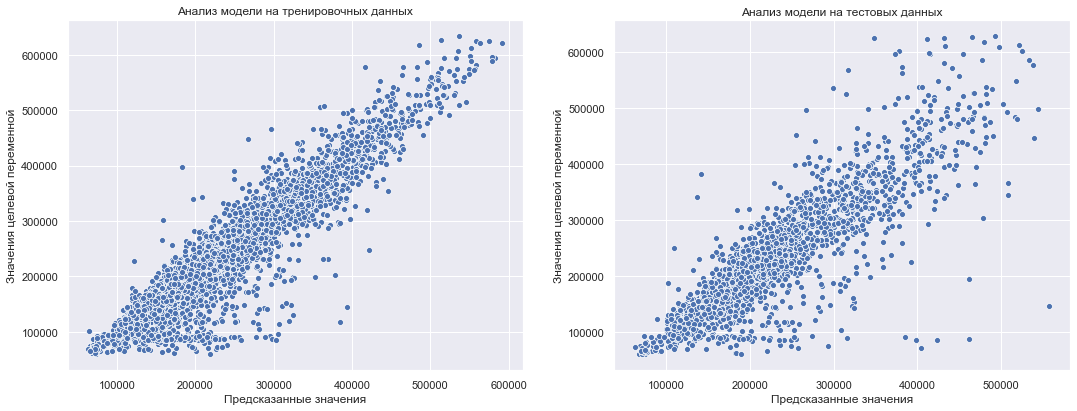

In [69]:
final_model = GradientBoostingRegressor(n_estimators=150, max_depth=5, random_state=42)
final_model.fit(X_train, y_train)
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [70]:
#Качество медели улучшилось после уменьшения max_depth с 7 до 5

#### Наиболее важные признаки

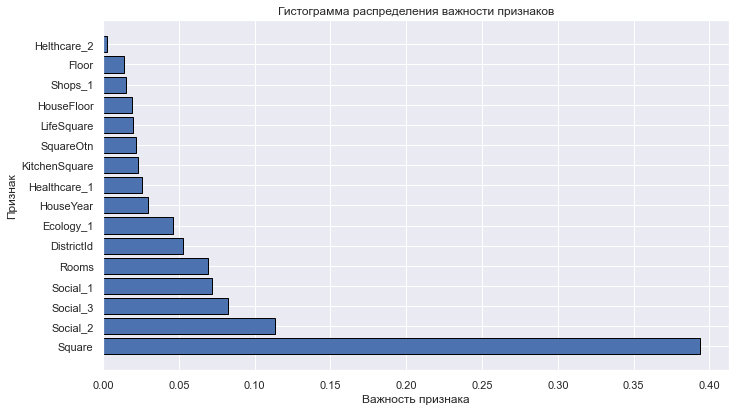

In [71]:
feature_importances = pd.DataFrame(zip(*[X_train.columns], final_model.feature_importances_),
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature_name'],feature_importances['importance'], ec="black")
plt.title("Гистограмма распределения важности признаков")
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.show()

### Вывод

In [72]:
#Разница качества моделей случайного леса и двух вариантов градиентного бустинга (R2) в пределах сотых долей - 
#они почти одинаковые, но веса признаков и их взаимное расположение различаются.
#На модель практически не влияет стандартизация параметров.
#Финальная модель градиентного бустинга наиболее точная, а графики предсказаний цены на тренировочных и тестовых данных схожи
#Конечные значения метрик:
#Train:	R2 = 0.878	MAE = 20628
#Test:	R2 = 0.767	MAE = 28050

## Сохранение модели

In [73]:
#with open(SCALER_FILE_PATH, 'wb') as file:
#    pickle.dump(scaler, file)

#with open(MODEL_FILE_PATH, 'wb') as file:
#    pickle.dump(final_model, file)

## Предсказание цены на тестовых данных

In [74]:
#Считывание данных
df_final = pd.read_csv(DATASET_PATH_TEST)

### Обработка прпусков

In [75]:
#Замена пропусков медианными значениями жилой площади сгруппированными по комнатам
df_final.loc[df_final['LifeSquare'].isna(), 'LifeSquare'] = \
df_final.groupby(['Rooms'])['LifeSquare'].transform(lambda x: x.median())

#Замена пропусков на медианные значения сгруппированные по признаку Helthcare_2
df_final.loc[df_final['Healthcare_1'].isna(), 'Healthcare_1'] =\
df_final.groupby(['Helthcare_2'])['Healthcare_1'].transform(lambda x: x.median())

df_final.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

### Обработка выбросов

In [76]:
df_final.loc[df_final['KitchenSquare'] > 50, 'KitchenSquare'] = df_final['KitchenSquare'].median()
df_final.loc[df_final['LifeSquare'] > 200, 'LifeSquare'] = df_final['LifeSquare'].median()
df_final.loc[df_final['Square'] > 200, 'Square'] = df_final['Square'].median()
df_final.loc[df_final['HouseFloor'] > 60, 'HouseFloor'] = df_final['HouseFloor'].median()
df_final.loc[df_final['HouseFloor'] == 0, 'HouseFloor'] = df_final['HouseFloor'].median()
medSqRoom = df_final.loc[(df_final['Rooms'] ==1, 'LifeSquare')].median()
df_final.loc[(df_final['Rooms'] == 0), 'Rooms'] =\
np.array(df_final.loc[(df_final['Rooms'] ==0, 'LifeSquare')] / medSqRoom + 0.5, dtype=int)
df_final.loc[(df_final['Rooms'] > 10, 'Rooms')] = 1

df_final['temp'] = df_final['Square']
df_final.loc[df_final['Square'] < df_final['LifeSquare'], 'Square'] =\
df_final.loc[df_final['Square'] < df_final['LifeSquare'], 'LifeSquare']
df_final.loc[df_final['temp'] < df_final['LifeSquare'], 'LifeSquare'] =\
df_final.loc[df_final['temp'] < df_final['LifeSquare'], 'temp']
df_final.drop("temp", axis=1, inplace=True)

#Добавление нового признака
df_final['SquareOtn'] = df_final['Rooms']/df_final['Square']

df_final.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,SquareOtn
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,5000.000000,5000.000000
mean,8412.595400,51.279200,1.90820,56.495972,34.980420,5.759600,8.632000,12.898000,1984.392600,0.119874,24.933800,5406.900000,8.262600,907.99440,1.31940,4.242800,0.033899
std,4832.674037,44.179466,0.81136,18.833856,15.943477,4.073663,5.483228,6.352989,18.573149,0.120070,17.532202,4026.614773,23.863762,813.54345,1.47994,4.777365,0.015798
min,1.000000,0.000000,1.00000,1.378543,0.333490,0.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.00000,0.00000,0.000000,0.006123
25%,4221.750000,21.000000,1.00000,41.989020,22.378133,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,540.00000,0.00000,1.000000,0.025969
50%,8320.500000,37.000000,2.00000,52.930550,32.830730,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,620.00000,1.00000,3.000000,0.032429
75%,12598.250000,77.000000,2.00000,66.392939,44.306318,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1084.00000,2.00000,6.000000,0.039374
max,16795.000000,212.000000,6.00000,189.679576,168.729035,44.000000,78.000000,48.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.00000,6.00000,23.000000,0.725404


### Предсказание цены

In [77]:
X_final = pd.DataFrame(df_final, columns=feature_names)
y_final_preds = final_model.predict(X_final)

### Сохранение файлов

In [78]:
#Файл CSV с прогнозами целевой переменной для тестового датасета
#df_y_pred = pd.DataFrame({'Id': [i for i in range(len(y_final_preds))],'Price' : y_final_preds})
df_y_pred = pd.DataFrame({'Id': df_final['Id'],'Price' : y_final_preds})

df_y_pred.to_csv(DATASET_PRED_PATH, index=False, encoding='utf-8')

df_y_pred.head()

,Id,Price
0,725,163545.129212
1,15856,213903.152514
2,5480,205346.389251
3,15664,364500.956328
4,14275,136682.860953
